In [3]:
import warnings
warnings.filterwarnings('ignore')

import ast, random, re
from datetime import date, datetime, timedelta

import numpy as np, pandas as pd, seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker
from yellowbrick.cluster import KElbowVisualizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                            precision_score, recall_score, f1_score, precision_recall_curve, 
                            roc_curve, roc_auc_score, auc, log_loss, plot_confusion_matrix, plot_roc_curve)
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [4]:
dataClickStream = pd.read_csv('click_stream.csv', error_bad_lines=False)
dataTransactions = pd.read_csv('transactions.csv', error_bad_lines=False)
dataProduct = pd.read_csv('product.csv', error_bad_lines=False)
dataCustomer = pd.read_csv('customer.csv', error_bad_lines=False)

pd.set_option('display.max_columns', 500)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

# Breakout Metadata

## **1.  Transaction**

In [6]:
transactions = dataTransactions

In [7]:
transactions['product_metadata'] = transactions['product_metadata'].apply(ast.literal_eval)

In [8]:
transaction_new = transactions.explode('product_metadata')

transaction_new = pd.concat([transaction_new.drop(['product_metadata'], axis=1), transaction_new['product_metadata'].apply(pd.Series)], axis=1)

## **2. Click Stream**

In [10]:
click = dataClickStream

In [11]:
click['event_metadata'] = click['event_metadata'].fillna('{}')
click['event_metadata'] = click['event_metadata'].apply(ast.literal_eval)

click_new = pd.concat([click.drop(['event_metadata'], axis=1), pd.json_normalize(click['event_metadata'])], axis=1)

click_new

,session_id,event_name,event_time,event_id,traffic_source,product_id,quantity,item_price,payment_status,search_keywords,promo_code,promo_amount
0,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,HOMEPAGE,2019-09-06T15:54:32.821085Z,9c4388c4-c95b-4678-b5ca-e9cbc0734109,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,fb0abf9e-fd1a-44dd-b5c0-2834d5a4b81c,SCROLL,2019-09-06T16:03:57.821085Z,4690e1f5-3f99-42d3-84a5-22c4c4d8500a,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7d440441-e67a-4d36-b324-80ffd636d166,HOMEPAGE,2019-09-01T12:05:10.322763Z,88aeaeb5-ec98-4859-852c-8abb483faf31,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7d440441-e67a-4d36-b324-80ffd636d166,ADD_TO_CART,2019-09-01T12:06:33.322763Z,934e306e-ecc6-472f-9ccb-12c8536910a2,MOBILE,15315.0,4.0,313529.0,NaN,NaN,NaN,NaN
4,7d440441-e67a-4d36-b324-80ffd636d166,BOOKING,2019-09-01T12:15:29.425431Z,9f4767a1-40fa-4c9c-9524-dfad18634d56,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
12833597,ad1063b0-a6e5-40a9-aed6-d1b45741e571,SEARCH,2021-06-07T04:37:53.354381Z,4b3b91a5-9bda-44de-87dc-153367071dfc,MOBILE,NaN,NaN,NaN,NaN,Bekas,NaN,NaN
12833598,64585e37-3fe7-48d7-b79b-ebcb70230eb2,HOMEPAGE,2021-05-05T11:44:14.985835Z,ab0acc87-9578-408a-b47f-c46996b8b52f,MOBILE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12833599,64585e37-3fe7-48d7-b79b-ebcb70230eb2,ADD_TO_CART,2021-05-05T11:53:10.985835Z,230d7b67-9934-42f9-9509-b330ac6ae777,MOBILE,19820.0,1.0,88918.0,NaN,NaN,NaN,NaN
12833600,64585e37-3fe7-48d7-b79b-ebcb70230eb2,BOOKING,2021-05-05T12:10:09.135142Z,8996ce49-c5dd-41ed-9231-28bfdb634cbe,MOBILE,NaN,NaN,NaN,Success,NaN,NaN,NaN


# Labeling

In [13]:
trx2 = transaction_new[transaction_new["payment_status"] == "Success"]

trx2.head()

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753


In [14]:
customer = dataCustomer

In [15]:
cust_trx= pd.merge(customer[["customer_id","first_join_date"]],trx2[["customer_id","created_at"]], on = "customer_id", how = "left")

cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07-21,NaN
1,8193,2017-07-16,NaN
2,7279,2020-08-23,2020-08-23T12:53:12.916342Z
3,7279,2020-08-23,2020-08-23T12:53:12.916342Z
4,7279,2020-08-23,2020-08-31T13:34:59.916342Z
...,...,...,...
1250788,40573,2021-07-17,2021-10-21T15:43:07.139547Z
1250789,40573,2021-07-17,2022-01-23T19:01:48.139547Z
1250790,40573,2021-07-17,2022-03-11T19:03:09.139547Z
1250791,40573,2021-07-17,2022-04-27T20:00:55.139547Z


In [16]:
cust_trx["created_at"] = pd.to_datetime(cust_trx["created_at"])
cust_trx["first_join_date"] = pd.to_datetime(cust_trx["first_join_date"])

cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07-21,NaT
1,8193,2017-07-16,NaT
2,7279,2020-08-23,2020-08-23 12:53:12.916342+00:00
3,7279,2020-08-23,2020-08-23 12:53:12.916342+00:00
4,7279,2020-08-23,2020-08-31 13:34:59.916342+00:00
...,...,...,...
1250788,40573,2021-07-17,2021-10-21 15:43:07.139547+00:00
1250789,40573,2021-07-17,2022-01-23 19:01:48.139547+00:00
1250790,40573,2021-07-17,2022-03-11 19:03:09.139547+00:00
1250791,40573,2021-07-17,2022-04-27 20:00:55.139547+00:00


In [17]:
cust_trx['created_at'] = cust_trx['created_at'].dt.strftime('%Y-%m')
cust_trx['first_join_date'] = cust_trx['first_join_date'].dt.strftime('%Y-%m')

cust_trx

,customer_id,first_join_date,created_at
0,2870,2019-07,NaN
1,8193,2017-07,NaN
2,7279,2020-08,2020-08
3,7279,2020-08,2020-08
4,7279,2020-08,2020-08
...,...,...,...
1250788,40573,2021-07,2021-10
1250789,40573,2021-07,2022-01
1250790,40573,2021-07,2022-03
1250791,40573,2021-07,2022-04


## Customer Never Transaction

In [18]:
cust_nvr_trx = cust_trx[cust_trx["created_at"].isna()]

cust_nvr_trx.shape

(49758, 3)

*A total of 49,758 (unique) customers never had a successful transaction, the remaining 50,242 (unique) customers had a successful transaction.*

## Customer Transaction

In [19]:
cust_trx2 = cust_trx[~cust_trx["created_at"].isna()]

cust_trx2

,customer_id,first_join_date,created_at
2,7279,2020-08,2020-08
3,7279,2020-08,2020-08
4,7279,2020-08,2020-08
5,7279,2020-08,2020-09
6,7279,2020-08,2020-09
...,...,...,...
1250788,40573,2021-07,2021-10
1250789,40573,2021-07,2022-01
1250790,40573,2021-07,2022-03
1250791,40573,2021-07,2022-04


In [20]:
# group by customer_id and created_at
cust_trx4 = cust_trx2.groupby(["customer_id","created_at"])['first_join_date'].first().reset_index()

cust_trx4

,customer_id,created_at,first_join_date
0,3,2018-08,2018-08
1,3,2018-09,2018-08
2,3,2018-10,2018-08
3,3,2018-11,2018-08
4,3,2018-12,2018-08
...,...,...,...
565536,99998,2020-07,2018-07
565537,99998,2021-01,2018-07
565538,99998,2021-07,2018-07
565539,99998,2022-01,2018-07


In [21]:
cust_trx4["created_at"] = pd.to_datetime(cust_trx4["created_at"])

In [22]:
size = cust_trx4.shape[0]
a = []

for i in range (size-1) :
    # if the value in row i in column 0 == the value in the next row in column 0 (is the same customer)
    if cust_trx4.iloc[i,0] == cust_trx4.iloc[i+1,0] :
        # then (created_at in the next month and created_at in the previous month) divided by 1 month
        # this is to find the month distance of the next successful transaction
        a.append((cust_trx4.iloc[i+1,1] - cust_trx4.iloc[i,1])/np.timedelta64(1,'M'))
    # if the value in row i in column 0 != value in the next row column 0 (is a different customer)
    else :
        # then (created_at in the current month and created_at in the current month) divided by 1 month
        # aka the result is 0, aka that is the last transaction of the customer, or maybe he only made one transaction
        a.append((cust_trx4.iloc[i,1] - cust_trx4.iloc[i,1])/np.timedelta64(1,'M'))

In [23]:
diff = pd.DataFrame(a, columns = ["diff"])

diff = round(diff)

diff.head()

,diff
0,1.0
1,1.0
2,1.0
3,1.0
4,2.0


In [24]:
# Just concat it if the number of rows is the same and you are sure it should be in that row.
cust_trx5 = pd.concat([cust_trx4, diff], axis=1)

cust_trx5["diff"] = cust_trx5["diff"].fillna(0)

cust_trx5

,customer_id,created_at,first_join_date,diff
0,3,2018-08-01,2018-08,1.0
1,3,2018-09-01,2018-08,1.0
2,3,2018-10-01,2018-08,1.0
3,3,2018-11-01,2018-08,1.0
4,3,2018-12-01,2018-08,2.0
...,...,...,...,...
565536,99998,2020-07-01,2018-07,6.0
565537,99998,2021-01-01,2018-07,6.0
565538,99998,2021-07-01,2018-07,6.0
565539,99998,2022-01-01,2018-07,0.0


*Here, 1 means the distance between the current month's transaction and the next transaction is 1 month apart. If 0 means there are no more transactions (not used), if 2, 3, and so on means the distance between this month's transaction and the next transaction is according to that number (churn).*

In [25]:
def renovated(df) : 
    if df["diff"] == 1 : 
        return 0
    elif df["diff"] == 0 :
        return 2
    else :
        return 1

cust_trx5["flagging"] = cust_trx5.apply(renovated, axis =1 )

*When the distance between the current transaction and the next is 1 month, it will be labeled 0, then it is considered a routine transaction. If the distance is 0 months, it will be labeled 2 and when the distance to the next transaction is above 1 month, it will be labeled 1 (churn).*

In [26]:
cust_trx5

,customer_id,created_at,first_join_date,diff,flagging
0,3,2018-08-01,2018-08,1.0,0
1,3,2018-09-01,2018-08,1.0,0
2,3,2018-10-01,2018-08,1.0,0
3,3,2018-11-01,2018-08,1.0,0
4,3,2018-12-01,2018-08,2.0,1
...,...,...,...,...,...
565536,99998,2020-07-01,2018-07,6.0,1
565537,99998,2021-01-01,2018-07,6.0,1
565538,99998,2021-07-01,2018-07,6.0,1
565539,99998,2022-01-01,2018-07,0.0,2


In [27]:
final_flagging = cust_trx5[cust_trx5["flagging"] <= 1].drop(columns=['diff'])

final_flagging

,customer_id,created_at,first_join_date,flagging
0,3,2018-08-01,2018-08,0
1,3,2018-09-01,2018-08,0
2,3,2018-10-01,2018-08,0
3,3,2018-11-01,2018-08,0
4,3,2018-12-01,2018-08,1
...,...,...,...,...
565534,99998,2019-07-01,2018-07,1
565535,99998,2020-01-01,2018-07,1
565536,99998,2020-07-01,2018-07,1
565537,99998,2021-01-01,2018-07,1


*Here, label 2 is dropped, which means that if the customer has only made one transaction during this time or that was his last transaction, then he will not be included in the creation of the feature.*

In [28]:
final_flagging["flagging"].value_counts(normalize = True)

0    0.620106
1    0.379894
Name: flagging, dtype: float64

* *1 is a churned customer*
* *0 is a customer who makes regular transactions*

# Feature Engineering

## 1. Payment Method

In [29]:
trx_method = trx2[['created_at','customer_id','payment_method']].copy()

trx_method['created_at'] = pd.to_datetime(trx_method["created_at"])
trx_method['created_at'] = trx_method['created_at'].dt.strftime('%Y-%m')
trx_method['created_at'] = pd.to_datetime(trx_method["created_at"])

trx_method

,created_at,customer_id,payment_method
0,2018-07-01,5868,Debit Card
1,2018-07-01,4774,Credit Card
2,2018-09-01,4774,OVO
3,2018-11-01,4774,Credit Card
4,2018-12-01,4774,Credit Card
...,...,...,...
852578,2020-11-01,25121,Debit Card
852580,2021-12-01,34829,OVO
852581,2021-12-01,99645,Credit Card
852582,2019-12-01,87319,Credit Card


In [30]:
def renovated(df) : 
    if  df['payment_method'] == 'Debit Card': 
        return 'Debit Card'
    elif df['payment_method'] == 'Credit Card' :
        return 'Credit Card'
    else :
        return 'Dompet Digital'
    
trx_method["payment_method2"] = trx_method.apply(renovated, axis =1 )

In [31]:
trx_method.head()

,created_at,customer_id,payment_method,payment_method2
0,2018-07-01,5868,Debit Card,Debit Card
1,2018-07-01,4774,Credit Card,Credit Card
2,2018-09-01,4774,OVO,Dompet Digital
3,2018-11-01,4774,Credit Card,Credit Card
4,2018-12-01,4774,Credit Card,Credit Card


In [32]:
dum = pd.get_dummies(trx_method["payment_method2"])

dum

,Credit Card,Debit Card,Dompet Digital
0,0,1,0
1,1,0,0
2,0,0,1
3,1,0,0
4,1,0,0
...,...,...,...
852578,0,1,0
852580,0,0,1
852581,1,0,0
852582,1,0,0


In [33]:
trx_method2 = pd.concat([trx_method, dum], axis=1)

trx_method2

,created_at,customer_id,payment_method,payment_method2,Credit Card,Debit Card,Dompet Digital
0,2018-07-01,5868,Debit Card,Debit Card,0,1,0
1,2018-07-01,4774,Credit Card,Credit Card,1,0,0
2,2018-09-01,4774,OVO,Dompet Digital,0,0,1
3,2018-11-01,4774,Credit Card,Credit Card,1,0,0
4,2018-12-01,4774,Credit Card,Credit Card,1,0,0
...,...,...,...,...,...,...,...
852578,2020-11-01,25121,Debit Card,Debit Card,0,1,0
852580,2021-12-01,34829,OVO,Dompet Digital,0,0,1
852581,2021-12-01,99645,Credit Card,Credit Card,1,0,0
852582,2019-12-01,87319,Credit Card,Credit Card,1,0,0


In [34]:
trx_method3 = trx_method2.drop(columns=['payment_method2'], inplace=True)

In [35]:
trx_method3 = trx_method2.groupby(["customer_id", "created_at"], as_index = False).agg({"Credit Card" : ["sum"], "Debit Card" : ["sum"],
                                                                                        "Dompet Digital" : ["sum"]})

trx_method3.columns = list(map(''.join,trx_method3.columns.values))

trx_method3

,customer_id,created_at,Credit Cardsum,Debit Cardsum,Dompet Digitalsum
0,3,2018-08-01,1,0,0
1,3,2018-09-01,1,0,0
2,3,2018-10-01,1,0,0
3,3,2018-11-01,1,0,0
4,3,2018-12-01,1,0,0
...,...,...,...,...,...
565536,99998,2020-07-01,2,0,0
565537,99998,2021-01-01,1,0,0
565538,99998,2021-07-01,0,1,0
565539,99998,2022-01-01,16,0,0


In [36]:
trx_method4 = pd.merge(final_flagging, trx_method3, how="left", on=["customer_id", "created_at"])

trx_method4

,customer_id,created_at,first_join_date,flagging,Credit Cardsum,Debit Cardsum,Dompet Digitalsum
0,3,2018-08-01,2018-08,0,1,0,0
1,3,2018-09-01,2018-08,0,1,0,0
2,3,2018-10-01,2018-08,0,1,0,0
3,3,2018-11-01,2018-08,0,1,0,0
4,3,2018-12-01,2018-08,1,1,0,0
...,...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,1,0,0
515295,99998,2020-01-01,2018-07,1,0,1,0
515296,99998,2020-07-01,2018-07,1,2,0,0
515297,99998,2021-01-01,2018-07,1,1,0,0


In [37]:
trx_method4.describe()

,customer_id,flagging,Credit Cardsum,Debit Cardsum,Dompet Digitalsum
count,515299.000000,515299.000000,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,0.750894,0.345432,1.046819
std,28972.061729,0.485361,1.650679,1.170148,1.884051
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,24742.000000,0.000000,0.000000,0.000000,0.000000
50%,49619.000000,0.000000,0.000000,0.000000,1.000000
75%,74951.000000,1.000000,1.000000,0.000000,1.000000
max,99998.000000,1.000000,52.000000,71.000000,54.000000


In [38]:
bins = [-np.inf, 0, np.inf]
labels = [1,2]

trx_method4['Bin_cc'] = pd.cut(trx_method4['Credit Cardsum'], bins=bins, labels=labels)
trx_method4['Bin_dg'] = pd.cut(trx_method4['Dompet Digitalsum'], bins=bins, labels=labels)

In [39]:
trx_method4

,customer_id,created_at,first_join_date,flagging,Credit Cardsum,Debit Cardsum,Dompet Digitalsum,Bin_cc,Bin_dg
0,3,2018-08-01,2018-08,0,1,0,0,2,1
1,3,2018-09-01,2018-08,0,1,0,0,2,1
2,3,2018-10-01,2018-08,0,1,0,0,2,1
3,3,2018-11-01,2018-08,0,1,0,0,2,1
4,3,2018-12-01,2018-08,1,1,0,0,2,1
...,...,...,...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,1,0,0,2,1
515295,99998,2020-01-01,2018-07,1,0,1,0,1,1
515296,99998,2020-07-01,2018-07,1,2,0,0,2,1
515297,99998,2021-01-01,2018-07,1,1,0,0,2,1


In [40]:
data_iv_1 = pd.crosstab(trx_method4["Bin_dg"], trx_method4["flagging"], margins=True, margins_name="Total")

data_iv_1

flagging,0,1,Total
Bin_dg,,,
1,142666,99395,242061
2,176874,96364,273238
Total,319540,195759,515299


In [41]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function non-event & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [42]:
# Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

# Let's sum IV
data_iv_1["IV"].sum()

0.015065981283402426

In [43]:
data_iv_1_2 = pd.crosstab(trx_method4["Bin_cc"], trx_method4["flagging"], margins=True, margins_name="Total")

data_iv_1_2

flagging,0,1,Total
Bin_cc,,,
1,191075,127519,318594
2,128465,68240,196705
Total,319540,195759,515299


In [44]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function non-event & event and save it to new columns %nonevent & %event
data_iv_1_2["%nonevent"] = data_iv_1_2.apply(nonevent, axis = 1)
data_iv_1_2["%event"] = data_iv_1_2.apply(event, axis = 1)

In [45]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1_2["WoE"] = np.log(data_iv_1_2["%event"]/data_iv_1_2["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1_2["IV"] = data_iv_1_2["WoE"]*(data_iv_1_2["%event"] - data_iv_1_2["%nonevent"])

#Let's sum IV
data_iv_1_2["IV"].sum()

0.012196147751578935

## 2. Total Transaction

In [46]:
total_trx = trx2[['created_at','customer_id','session_id']].copy()

total_trx['created_at'] = pd.to_datetime(total_trx["created_at"])
total_trx['created_at'] = total_trx['created_at'].dt.strftime('%Y-%m')
total_trx['created_at'] = pd.to_datetime(total_trx["created_at"])

total_trx2 = total_trx.groupby(['created_at','customer_id']).count().reset_index()
total_trx2 = total_trx2.rename(columns={'session_id' : 'total_transaction'})

total_trx2

,created_at,customer_id,total_transaction
0,2016-06-01,74089,1
1,2016-07-01,221,1
2,2016-07-01,837,1
3,2016-07-01,933,1
4,2016-07-01,1022,1
...,...,...,...
565536,2022-07-01,99936,14
565537,2022-07-01,99976,5
565538,2022-07-01,99986,1
565539,2022-07-01,99988,3


In [47]:
total_trx3 = final_flagging.merge(total_trx2, on=['customer_id','created_at'], how='left')

total_trx3

,customer_id,created_at,first_join_date,flagging,total_transaction
0,3,2018-08-01,2018-08,0,1
1,3,2018-09-01,2018-08,0,1
2,3,2018-10-01,2018-08,0,1
3,3,2018-11-01,2018-08,0,1
4,3,2018-12-01,2018-08,1,1
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,1
515295,99998,2020-01-01,2018-07,1,1
515296,99998,2020-07-01,2018-07,1,2
515297,99998,2021-01-01,2018-07,1,1


In [48]:
total_trx3.describe()

,customer_id,flagging,total_transaction
count,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,2.143146
std,28972.061729,0.485361,2.400546
min,3.000000,0.000000,1.000000
25%,24742.000000,0.000000,1.000000
50%,49619.000000,0.000000,1.000000
75%,74951.000000,1.000000,2.000000
max,99998.000000,1.000000,78.000000


In [49]:
# determine category
def func(row):
    if row <= 1:
        return 1
    elif row <= 2:
        return 2
    else:
        return 3

total_trx3['total_transactions'] = total_trx3['total_transaction'].apply(func)

In [50]:
total_trx3['total_transactions'].value_counts()

1    311090
3    114257
2     89952
Name: total_transactions, dtype: int64

In [51]:
total_trx3

,customer_id,created_at,first_join_date,flagging,total_transaction,total_transactions
0,3,2018-08-01,2018-08,0,1,1
1,3,2018-09-01,2018-08,0,1,1
2,3,2018-10-01,2018-08,0,1,1
3,3,2018-11-01,2018-08,0,1,1
4,3,2018-12-01,2018-08,1,1,1
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,1,1
515295,99998,2020-01-01,2018-07,1,1,1
515296,99998,2020-07-01,2018-07,1,2,2
515297,99998,2021-01-01,2018-07,1,1,1


In [52]:
data_iv_2 = pd.crosstab(total_trx3["total_transactions"], total_trx3["flagging"], margins=True, margins_name="Total")

data_iv_2

flagging,0,1,Total
total_transactions,,,
1,150053,161037,311090
2,73477,16475,89952
3,96010,18247,114257
Total,319540,195759,515299


In [53]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_2["%nonevent"] = data_iv_2.apply(nonevent, axis = 1)
data_iv_2["%event"] = data_iv_2.apply(event, axis = 1)

In [54]:
data_iv_2

flagging,0,1,Total,%nonevent,%event
total_transactions,,,,,
1,150053,161037,311090,0.469591,0.822629
2,73477,16475,89952,0.229946,0.084160
3,96010,18247,114257,0.300463,0.093212
Total,319540,195759,515299,1.000000,1.000000


In [55]:
#Let's calculate WoE and save it to new a column WoE
data_iv_2["WoE"] = np.log(data_iv_2["%event"]/data_iv_2["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_2["IV"] = data_iv_2["WoE"]*(data_iv_2["%event"] - data_iv_2["%nonevent"])

#Let's sum IV
data_iv_2["IV"].sum()

0.5870415111434116

In [56]:
data_iv_2

flagging,0,1,Total,%nonevent,%event,WoE,IV
total_transactions,,,,,,,
1,150053,161037,311090,0.469591,0.822629,0.560644,0.197929
2,73477,16475,89952,0.229946,0.084160,-1.005130,0.146534
3,96010,18247,114257,0.300463,0.093212,-1.170454,0.242578
Total,319540,195759,515299,1.000000,1.000000,0.000000,0.000000


## 3. Shipment Date Limit

In [57]:
trx_datelimit = trx2[['created_at','customer_id','shipment_date_limit']].copy()

trx_datelimit['created_at'] = pd.to_datetime(trx_datelimit["created_at"])
trx_datelimit['shipment_date_limit'] = pd.to_datetime(trx_datelimit["shipment_date_limit"])

trx_datelimit['diff_datelimit'] = trx_datelimit['shipment_date_limit'] - trx_datelimit['created_at']

trx_datelimit['created_at'] = trx_datelimit['created_at'].dt.strftime('%Y-%m')
trx_datelimit['created_at'] = pd.to_datetime(trx_datelimit["created_at"])

trx_datelimit2 = trx_datelimit.groupby(['customer_id','created_at'])[['diff_datelimit']].mean().reset_index()

trx_datelimit2

,customer_id,created_at,diff_datelimit
0,3,2018-08-01,1 days 10:14:11.973051
1,3,2018-09-01,3 days 00:32:02.888480
2,3,2018-10-01,5 days 10:19:03.419877
3,3,2018-11-01,3 days 09:56:18.435177
4,3,2018-12-01,3 days 01:42:02.245432
...,...,...,...
565536,99998,2020-07-01,4 days 19:30:47.205880
565537,99998,2021-01-01,1 days 00:52:13.840735
565538,99998,2021-07-01,2 days 03:36:13.194951
565539,99998,2022-01-01,1 days 17:13:40.615007


In [58]:
trx_datelimit2.describe()

,customer_id,diff_datelimit
count,565541.000000,565541
mean,49868.684955,3 days 12:26:44.867104319
std,28969.757982,1 days 08:12:25.663020245
min,3.000000,1 days 00:00:02.200453
25%,24741.000000,2 days 10:29:17.947286400
50%,49624.000000,3 days 12:28:55.253620
75%,74948.000000,4 days 14:21:41.798299
max,99999.000000,6 days 00:59:59.332085


In [59]:
# determine category
def func(row):
    if row <= timedelta(days = 2):
        return 1
    elif row <= timedelta(days = 3):
        return 2
    elif row <= timedelta(days = 4):
        return 3
    else:
        return 4

trx_datelimit2['diff_datelimits'] = trx_datelimit2['diff_datelimit'].apply(func)

In [60]:
trx_datelimit2['diff_datelimits'].value_counts()

4    218112
3    137761
2    119247
1     90421
Name: diff_datelimits, dtype: int64

In [62]:
trx_datelimit3 = final_flagging.merge(trx_datelimit2, on=['customer_id','created_at'])

trx_datelimit3

,customer_id,created_at,first_join_date,flagging,diff_datelimit,diff_datelimits
0,3,2018-08-01,2018-08,0,1 days 10:14:11.973051,1
1,3,2018-09-01,2018-08,0,3 days 00:32:02.888480,3
2,3,2018-10-01,2018-08,0,5 days 10:19:03.419877,4
3,3,2018-11-01,2018-08,0,3 days 09:56:18.435177,3
4,3,2018-12-01,2018-08,1,3 days 01:42:02.245432,3
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,3 days 01:25:27.973391,3
515295,99998,2020-01-01,2018-07,1,2 days 05:33:26.784554,2
515296,99998,2020-07-01,2018-07,1,4 days 19:30:47.205880,4
515297,99998,2021-01-01,2018-07,1,1 days 00:52:13.840735,1


In [63]:
data_iv_3 = pd.crosstab(trx_datelimit3["diff_datelimits"], trx_datelimit3["flagging"], margins=True, margins_name="Total")

data_iv_3

flagging,0,1,Total
diff_datelimits,,,
1,44036,37578,81614
2,69706,39282,108988
3,87169,39330,126499
4,118629,79569,198198
Total,319540,195759,515299


In [64]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_3["%nonevent"] = data_iv_3.apply(nonevent, axis = 1)
data_iv_3["%event"] = data_iv_3.apply(event, axis = 1)

In [65]:
#Let's calculate WoE and save it to new a column WoE
data_iv_3["WoE"] = np.log(data_iv_3["%event"]/data_iv_3["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_3["IV"] = data_iv_3["WoE"]*(data_iv_3["%event"] - data_iv_3["%nonevent"])

#Let's sum IV
data_iv_3["IV"].sum()

0.04458391145977732

## 4. Shipment Fee

In [66]:
trx_shipment = trx2[['created_at','customer_id','shipment_fee']].copy()

trx_shipment['created_at'] = pd.to_datetime(trx_shipment["created_at"])
trx_shipment['created_at'] = trx_shipment['created_at'].dt.strftime('%Y-%m')
trx_shipment['created_at'] = pd.to_datetime(trx_shipment["created_at"])

trx_shipment2 = trx_shipment.groupby(['customer_id','created_at']).sum().reset_index()

trx_shipment2

,customer_id,created_at,shipment_fee
0,3,2018-08-01,0
1,3,2018-09-01,10000
2,3,2018-10-01,10000
3,3,2018-11-01,0
4,3,2018-12-01,10000
...,...,...,...
565536,99998,2020-07-01,20000
565537,99998,2021-01-01,10000
565538,99998,2021-07-01,0
565539,99998,2022-01-01,160000


In [67]:
trx_shipment3 = final_flagging.merge(trx_shipment2, on=['customer_id','created_at'], how='left')

trx_shipment3

,customer_id,created_at,first_join_date,flagging,shipment_fee
0,3,2018-08-01,2018-08,0,0
1,3,2018-09-01,2018-08,0,10000
2,3,2018-10-01,2018-08,0,10000
3,3,2018-11-01,2018-08,0,0
4,3,2018-12-01,2018-08,1,10000
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,10000
515295,99998,2020-01-01,2018-07,1,0
515296,99998,2020-07-01,2018-07,1,20000
515297,99998,2021-01-01,2018-07,1,10000


In [68]:
trx_shipment3.describe()

,customer_id,flagging,shipment_fee
count,515299.000000,515299.000000,5.152990e+05
mean,49873.821358,0.379894,1.970034e+04
std,28972.061729,0.485361,3.275937e+04
min,3.000000,0.000000,0.000000e+00
25%,24742.000000,0.000000,1.000000e+04
50%,49619.000000,0.000000,1.000000e+04
75%,74951.000000,1.000000,2.000000e+04
max,99998.000000,1.000000,1.640000e+06


In [69]:
def func(x):
    if x <= 0:
        return 1 
    elif x <= 5000:
        return 2
    elif x <= 10000:
        return 3
    elif x <= 15000:
        return 4
    else:
        return 5

trx_shipment3['shipments_fee'] = trx_shipment3['shipment_fee'].apply(func)

In [70]:
data_iv_4 = pd.crosstab(trx_shipment3["shipments_fee"], trx_shipment3["flagging"], margins=True, margins_name="Total")

data_iv_4

flagging,0,1,Total
shipments_fee,,,
1,53195,50371,103566
2,13308,11178,24486
3,105964,88706,194670
4,19247,11126,30373
5,127826,34378,162204
Total,319540,195759,515299


In [71]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_4["%nonevent"] = data_iv_4.apply(nonevent, axis = 1)
data_iv_4["%event"] = data_iv_4.apply(event, axis = 1)

In [72]:
#Let's calculate WoE and save it to new a column WoE
data_iv_4["WoE"] = np.log(data_iv_4["%event"]/data_iv_4["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_4["IV"] = data_iv_4["WoE"]*(data_iv_4["%event"] - data_iv_4["%nonevent"])

#Let's sum IV
data_iv_4["IV"].sum()

0.26732525124476203

## 5. Traffic Source

In [73]:
# because each device must have its session, it is impossible for different devices to have the same session_id
click_traffic = click_new.groupby(['session_id'])[['traffic_source']].first().reset_index()

click_traffic

,session_id,traffic_source
0,00001f29-3ede-4445-95f0-0178934e32ba,MOBILE
1,00003eca-954b-4150-aee1-63fc62f395cf,MOBILE
2,0000425b-ddc8-4459-a240-6ba814dac132,MOBILE
3,00005746-17ec-449c-9c5c-699a3ea9304a,MOBILE
4,0000649b-9514-4600-979b-42166a798996,MOBILE
...,...,...
895198,ffffce53-1ba7-4d7d-a14a-ffa7079cfbff,WEB
895199,ffffd3d9-79db-459e-a427-388204a7aac7,MOBILE
895200,ffffdf8e-dea1-42bc-9839-7662675c0d38,MOBILE
895201,fffff7cf-2a18-4303-9c12-aa836ae3b543,MOBILE


In [74]:
trx_click = pd.merge(trx2[['created_at','customer_id','session_id']], click_traffic[['session_id','traffic_source']], on='session_id')

trx_click['created_at'] = pd.to_datetime(trx_click["created_at"])
trx_click['created_at'] = trx_click['created_at'].dt.strftime('%Y-%m')
trx_click['created_at'] = pd.to_datetime(trx_click["created_at"])

trx_click2 = trx_click.groupby(['customer_id','created_at']).first().reset_index()

trx_click2

,customer_id,created_at,session_id,traffic_source
0,3,2018-08-01,f03b6825-1e6e-4916-bf71-f94ecbcbaee5,MOBILE
1,3,2018-09-01,36673b2f-940a-42b5-994d-1cce4796b55f,MOBILE
2,3,2018-10-01,93e1d3c4-bed1-4ef4-b79f-e24a79e905b7,MOBILE
3,3,2018-11-01,8356370c-267e-4530-a2d3-1830e4be3f2b,MOBILE
4,3,2018-12-01,ef7f4829-e7d1-4513-861b-1fbbc6e41bbf,MOBILE
...,...,...,...,...
565534,99998,2020-07-01,4c018e81-af7a-429b-8aad-e182c312079a,MOBILE
565535,99998,2021-01-01,11f2cef4-901a-4bec-b691-bfa32fa70f4d,MOBILE
565536,99998,2021-07-01,19d9eda5-1a4c-43b4-8f38-0b6b5c00841c,MOBILE
565537,99998,2022-01-01,4fc4d81b-4b29-4aef-bd1f-263c373950d1,MOBILE


In [75]:
def renovated(trx_click2) : 
    if search("MOBILE", trx_click2['traffic_source']) : 
        return 1
    else :
        return 2
    
trx_click2['traffic_source'] = trx_click2.apply(renovated, axis =1 )

In [76]:
trx_click2['traffic_source'].value_counts()

1    508970
2     56569
Name: traffic_source, dtype: int64

In [77]:
trx_click3 = final_flagging.merge(trx_click2, on=['customer_id','created_at'], how='left')

trx_click3

,customer_id,created_at,first_join_date,flagging,session_id,traffic_source
0,3,2018-08-01,2018-08,0,f03b6825-1e6e-4916-bf71-f94ecbcbaee5,1.0
1,3,2018-09-01,2018-08,0,36673b2f-940a-42b5-994d-1cce4796b55f,1.0
2,3,2018-10-01,2018-08,0,93e1d3c4-bed1-4ef4-b79f-e24a79e905b7,1.0
3,3,2018-11-01,2018-08,0,8356370c-267e-4530-a2d3-1830e4be3f2b,1.0
4,3,2018-12-01,2018-08,1,ef7f4829-e7d1-4513-861b-1fbbc6e41bbf,1.0
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,d009836a-c8ad-41ee-b2a0-89e787869a00,1.0
515295,99998,2020-01-01,2018-07,1,34be3c62-f581-49b6-9dd7-b5221d5a8721,1.0
515296,99998,2020-07-01,2018-07,1,4c018e81-af7a-429b-8aad-e182c312079a,1.0
515297,99998,2021-01-01,2018-07,1,11f2cef4-901a-4bec-b691-bfa32fa70f4d,1.0


In [78]:
data_iv_5 = pd.crosstab(trx_click3['traffic_source'], trx_click3["flagging"], margins=True, margins_name="Total")

data_iv_5

flagging,0,1,Total
traffic_source,,,
1.0,287510,176279,463789
2.0,32030,19479,51509
Total,319540,195758,515298


In [79]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/352118)
def event(df) : 
    return (df[1]/196027)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_5["%nonevent"] = data_iv_5.apply(nonevent, axis = 1)
data_iv_5["%event"] = data_iv_5.apply(event, axis = 1)

In [80]:
#Let's calculate WoE and save it to new a column WoE
data_iv_5["WoE"] = np.log(data_iv_5["%event"]/data_iv_5["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_5["IV"] = data_iv_5["WoE"]*(data_iv_5["%event"] - data_iv_5["%nonevent"])

#Let's sum IV
data_iv_5["IV"].sum()

0.017453333474544617

## 6. Click Item Detail

In [81]:
click_new['event_name'].value_counts()

CLICK          2498038
HOMEPAGE       2487126
ADD_TO_CART    1937157
SCROLL         1663571
ITEM_DETAIL    1290396
SEARCH         1173266
BOOKING         852582
PROMO_PAGE      604931
ADD_PROMO       326535
Name: event_name, dtype: int64

In [82]:
click_item = click_new[click_new['event_name'] == 'ITEM_DETAIL'][['session_id']]

click_item2 = trx2.iloc[:,[0,1,3]].merge(click_item, on='session_id')

click_item2['created_at'] = pd.to_datetime(click_item2["created_at"])
click_item2['created_at'] = click_item2['created_at'].dt.strftime('%Y-%m')
click_item2['created_at'] = pd.to_datetime(click_item2["created_at"])

In [83]:
click_item3 = click_item2.groupby(['customer_id','created_at']).count().reset_index()

click_item3 = click_item3.rename(columns={'session_id' : 'click_detail_item'})

click_item3

,customer_id,created_at,click_detail_item
0,3,2018-10-01,2
1,3,2018-11-01,2
2,3,2018-12-01,1
3,3,2019-02-01,1
4,3,2019-03-01,2
...,...,...,...
363257,99998,2019-07-01,27
363258,99998,2021-01-01,2
363259,99998,2021-07-01,2
363260,99998,2022-01-01,32


In [84]:
click_item4 = final_flagging.merge(click_item3, on=['customer_id','created_at'], how='left')

click_item4 = click_item4.fillna(0)

click_item4

,customer_id,created_at,first_join_date,flagging,click_detail_item
0,3,2018-08-01,2018-08,0,0.0
1,3,2018-09-01,2018-08,0,0.0
2,3,2018-10-01,2018-08,0,2.0
3,3,2018-11-01,2018-08,0,2.0
4,3,2018-12-01,2018-08,1,1.0
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,27.0
515295,99998,2020-01-01,2018-07,1,0.0
515296,99998,2020-07-01,2018-07,1,0.0
515297,99998,2021-01-01,2018-07,1,2.0


In [85]:
click_item4.describe()

,customer_id,flagging,click_detail_item
count,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,3.282605
std,28972.061729,0.485361,7.314569
min,3.000000,0.000000,0.000000
25%,24742.000000,0.000000,0.000000
50%,49619.000000,0.000000,1.000000
75%,74951.000000,1.000000,4.000000
max,99998.000000,1.000000,420.000000


In [86]:
def func(row):
    if row <= 1:
        return 1
    elif row <= 4:
        return 2
    else:
        return 3

click_item4['click_detail_items'] = click_item4['click_detail_item'].apply(func)

In [87]:
data_iv_6 = pd.crosstab(click_item4["click_detail_items"], click_item4["flagging"], margins=True, margins_name="Total")

data_iv_6

flagging,0,1,Total
click_detail_items,,,
1,145788,136455,282243
2,89471,43268,132739
3,84281,16036,100317
Total,319540,195759,515299


In [88]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_6["%nonevent"] = data_iv_6.apply(nonevent, axis = 1)
data_iv_6["%event"] = data_iv_6.apply(event, axis = 1)

In [89]:
#Let's calculate WoE and save it to new a column WoE
data_iv_6["WoE"] = np.log(data_iv_6["%event"]/data_iv_6["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_6["IV"] = data_iv_6["WoE"]*(data_iv_6["%event"] - data_iv_6["%nonevent"])

#Let's sum IV
data_iv_6["IV"].sum()

0.32864292394681305

## 7. Total Amount

In [90]:
trx_amount = trx2[['created_at','customer_id','total_amount']].copy()

trx_amount['created_at'] = pd.to_datetime(trx_amount["created_at"])
trx_amount['created_at'] = trx_amount['created_at'].dt.strftime('%Y-%m')
trx_amount['created_at'] = pd.to_datetime(trx_amount["created_at"])

trx_amount2 = trx_amount.groupby(['created_at','customer_id']).sum().reset_index()

trx_amount2

,created_at,customer_id,total_amount
0,2016-06-01,74089,640795
1,2016-07-01,221,467436
2,2016-07-01,837,379716
3,2016-07-01,933,237978
4,2016-07-01,1022,244862
...,...,...,...
565536,2022-07-01,99936,36570250
565537,2022-07-01,99976,3283919
565538,2022-07-01,99986,379377
565539,2022-07-01,99988,2117835


In [91]:
trx_amount3 = final_flagging.merge(trx_amount2, on=['customer_id','created_at'], how='left')

trx_amount3

,customer_id,created_at,first_join_date,flagging,total_amount
0,3,2018-08-01,2018-08,0,826597
1,3,2018-09-01,2018-08,0,163784
2,3,2018-10-01,2018-08,0,124932
3,3,2018-11-01,2018-08,0,247902
4,3,2018-12-01,2018-08,1,181237
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,384029
515295,99998,2020-01-01,2018-07,1,216338
515296,99998,2020-07-01,2018-07,1,1068674
515297,99998,2021-01-01,2018-07,1,366178


In [92]:
trx_amount3.describe()

,customer_id,flagging,total_amount
count,515299.000000,515299.000000,5.152990e+05
mean,49873.821358,0.379894,2.539591e+06
std,28972.061729,0.485361,1.153880e+07
min,3.000000,0.000000,1.520300e+04
25%,24742.000000,0.000000,2.375340e+05
50%,49619.000000,0.000000,4.144470e+05
75%,74951.000000,1.000000,1.166800e+06
max,99998.000000,1.000000,8.931705e+08


In [93]:
def func(row):
    if row <= 2.371495e+05:
        return 1
    elif row <= 4.019420e+05:
        return 2
    elif row <= 1.166800e+06:
        return 3
    else:
        return 4

trx_amount3['total_amount_paid'] = trx_amount3['total_amount'].apply(func)

In [94]:
trx_amount3['total_amount_paid'].value_counts()

3    134553
4    128824
1    128410
2    123512
Name: total_amount_paid, dtype: int64

In [95]:
data_iv_7 = pd.crosstab(trx_amount3["total_amount_paid"], trx_amount3["flagging"], margins=True, margins_name="Total")

data_iv_7

flagging,0,1,Total
total_amount_paid,,,
1,62418,65992,128410
2,64751,58761,123512
3,95609,38944,134553
4,96762,32062,128824
Total,319540,195759,515299


In [96]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_7["%nonevent"] = data_iv_7.apply(nonevent, axis = 1)
data_iv_7["%event"] = data_iv_7.apply(event, axis = 1)

In [97]:
#Let's calculate WoE and save it to new a column WoE
data_iv_7["WoE"] = np.log(data_iv_7["%event"]/data_iv_7["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_7["IV"] = data_iv_7["WoE"]*(data_iv_7["%event"] - data_iv_7["%nonevent"])

#Let's sum IV
data_iv_7["IV"].sum()

0.24205684652228604

## 8. Promo Amount

In [98]:
trx2

,created_at,customer_id,booking_id,session_id,payment_method,payment_status,promo_amount,promo_code,shipment_fee,shipment_date_limit,shipment_location_lat,shipment_location_long,total_amount,product_id,quantity,item_price
0,2018-07-29T15:22:01.458193Z,5868,186e2bee-0637-4710-8981-50c2d737bc42,3abaa6ce-e320-4e51-9469-d9f3fa328e86,Debit Card,Success,1415,WEEKENDSERU,10000,2018-08-03T05:07:24.812676Z,-8.227893,111.969107,199832,54728,1,191247
1,2018-07-30T12:40:22.365620Z,4774,caadb57b-e808-4f94-9e96-8a7d4c9898db,2ee5ead1-f13e-4759-92df-7ff48475e970,Credit Card,Success,0,NaN,10000,2018-08-03T01:29:03.415705Z,3.013470,107.802514,155526,16193,1,145526
2,2018-09-15T11:51:17.365620Z,4774,6000fffb-9c1a-4f4a-9296-bc8f6b622b50,93325fb6-eb00-4268-bb0e-6471795a0ad0,OVO,Success,0,NaN,10000,2018-09-18T08:41:49.422380Z,-2.579428,115.743885,550696,53686,4,135174
3,2018-11-01T11:23:48.365620Z,4774,f5e530a7-4350-4cd1-a3bc-525b5037bcab,bcad5a61-1b67-448d-8ff4-781d67bc56e4,Credit Card,Success,0,NaN,0,2018-11-05T17:42:27.954235Z,-3.602334,120.363824,271012,20228,1,271012
4,2018-12-18T11:20:30.365620Z,4774,0efc0594-dbbf-4f9a-b0b0-a488cfddf8a2,df1042ab-13e6-4072-b9d2-64a81974c51a,Credit Card,Success,0,NaN,0,2018-12-23T17:24:07.361785Z,-3.602334,120.363824,198753,55220,1,198753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
852578,2020-11-12T18:19:20.074873Z,25121,7fdc05d1-234b-4889-a343-587ffc0635d5,33c3bf4f-0f24-4eb8-879d-906bf7e7736a,Debit Card,Success,0,NaN,10000,2020-11-18T18:06:06.493534Z,-6.286732,106.902229,287688,42915,1,277688
852580,2021-12-09T07:35:18.222046Z,34829,ccde6b83-ee42-4cce-b2cd-976574886eac,954e1211-4d45-4d0b-ba84-53e80119592c,OVO,Success,5010,AZ2022,10000,2021-12-12T07:52:44.803822Z,-8.677264,115.176947,359203,19394,1,354213
852581,2021-12-11T01:20:36.944593Z,99645,5bcd3434-1dc6-44bb-ae63-fd19714cbd6c,e6e6c108-abd0-49a2-b0a5-691117f9cfe1,Credit Card,Success,2181,WEEKENDSERU,5000,2021-12-12T13:28:22.848703Z,-6.185498,106.831093,1158159,13079,4,288835
852582,2019-12-18T11:01:09.623382Z,87319,af7f291a-b01b-4bfd-89a9-237b16368b15,bb6e5426-a3f3-426a-b99d-79173eaa234b,Credit Card,Success,4503,AZ2022,0,2019-12-23T22:56:46.831720Z,-7.155977,110.891858,184143,11312,1,188646


In [99]:
trx_promo = trx2[['created_at','customer_id','promo_amount']].copy()

trx_promo['created_at'] = pd.to_datetime(trx_promo["created_at"])
trx_promo['created_at'] = trx_promo['created_at'].dt.strftime('%Y-%m')
trx_promo['created_at'] = pd.to_datetime(trx_promo["created_at"])

trx_promo2_first = trx_promo.groupby(['customer_id','created_at'])[['promo_amount']].sum().reset_index()

trx_promo2_first

,customer_id,created_at,promo_amount
0,3,2018-08-01,8073
1,3,2018-09-01,0
2,3,2018-10-01,8828
3,3,2018-11-01,3415
4,3,2018-12-01,2645
...,...,...,...
565536,99998,2020-07-01,0
565537,99998,2021-01-01,8569
565538,99998,2021-07-01,0
565539,99998,2022-01-01,31264


In [100]:
trx_promo2 = trx_promo2_first.groupby(['customer_id','created_at'])[['promo_amount']].sum().reset_index()

trx_promo2

,customer_id,created_at,promo_amount
0,3,2018-08-01,8073
1,3,2018-09-01,0
2,3,2018-10-01,8828
3,3,2018-11-01,3415
4,3,2018-12-01,2645
...,...,...,...
565536,99998,2020-07-01,0
565537,99998,2021-01-01,8569
565538,99998,2021-07-01,0
565539,99998,2022-01-01,31264


In [101]:
trx_promo3 = final_flagging.merge(trx_promo2, on=['customer_id','created_at'], how='left')

trx_promo3 = trx_promo3.fillna(0)

trx_promo3

,customer_id,created_at,first_join_date,flagging,promo_amount
0,3,2018-08-01,2018-08,0,8073
1,3,2018-09-01,2018-08,0,0
2,3,2018-10-01,2018-08,0,8828
3,3,2018-11-01,2018-08,0,3415
4,3,2018-12-01,2018-08,1,2645
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,5670
515295,99998,2020-01-01,2018-07,1,4912
515296,99998,2020-07-01,2018-07,1,0
515297,99998,2021-01-01,2018-07,1,8569


In [102]:
trx_promo3.describe()

,customer_id,flagging,promo_amount
count,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,4438.318312
std,28972.061729,0.485361,9458.836181
min,3.000000,0.000000,0.000000
25%,24742.000000,0.000000,0.000000
50%,49619.000000,0.000000,0.000000
75%,74951.000000,1.000000,5805.000000
max,99998.000000,1.000000,353718.000000


In [103]:
def func(x):
    if x <= 0:
        return 1
    elif x <= 5850:
        return 2
    else:
        return 3

trx_promo3['promo_amount_used'] = trx_promo3['promo_amount'].apply(func)

trx_promo3

,customer_id,created_at,first_join_date,flagging,promo_amount,promo_amount_used
0,3,2018-08-01,2018-08,0,8073,3
1,3,2018-09-01,2018-08,0,0,1
2,3,2018-10-01,2018-08,0,8828,3
3,3,2018-11-01,2018-08,0,3415,2
4,3,2018-12-01,2018-08,1,2645,2
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,5670,2
515295,99998,2020-01-01,2018-07,1,4912,2
515296,99998,2020-07-01,2018-07,1,0,1
515297,99998,2021-01-01,2018-07,1,8569,3


In [104]:
trx_promo3['promo_amount_used'].value_counts()

1    269893
3    127631
2    117775
Name: promo_amount_used, dtype: int64

In [105]:
data_iv_8 = pd.crosstab(trx_promo3["promo_amount_used"], trx_promo3["flagging"], margins=True, margins_name="Total")

data_iv_8

flagging,0,1,Total
promo_amount_used,,,
1,154835,115058,269893
2,73033,44742,117775
3,91672,35959,127631
Total,319540,195759,515299


In [106]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_8["%nonevent"] = data_iv_8.apply(nonevent, axis = 1)
data_iv_8["%event"] = data_iv_8.apply(event, axis = 1)

In [107]:
#Let's calculate WoE and save it to new a column WoE
data_iv_8["WoE"] = np.log(data_iv_8["%event"]/data_iv_8["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_8["IV"] = data_iv_8["WoE"]*(data_iv_8["%event"] - data_iv_8["%nonevent"])

#Let's sum IV
data_iv_8["IV"].sum()

0.06593418433768815

## 9. Promo Used Count

In [108]:
# how many times does he use the promo each month (seen based on his orders)
promo_used = trx_promo2_first.copy()

promo_used['promo_count'] = promo_used['promo_amount'].apply(lambda x : 1 if x > 0 else 0)

promo_used

,customer_id,created_at,promo_amount,promo_count
0,3,2018-08-01,8073,1
1,3,2018-09-01,0,0
2,3,2018-10-01,8828,1
3,3,2018-11-01,3415,1
4,3,2018-12-01,2645,1
...,...,...,...,...
565536,99998,2020-07-01,0,0
565537,99998,2021-01-01,8569,1
565538,99998,2021-07-01,0,0
565539,99998,2022-01-01,31264,1


In [109]:
promo_used2 = promo_used.groupby(['customer_id','created_at'])[['promo_amount','promo_count']].sum().reset_index()

promo_used2

,customer_id,created_at,promo_amount,promo_count
0,3,2018-08-01,8073,1
1,3,2018-09-01,0,0
2,3,2018-10-01,8828,1
3,3,2018-11-01,3415,1
4,3,2018-12-01,2645,1
...,...,...,...,...
565536,99998,2020-07-01,0,0
565537,99998,2021-01-01,8569,1
565538,99998,2021-07-01,0,0
565539,99998,2022-01-01,31264,1


In [110]:
promo_used3 = final_flagging.merge(promo_used2, on=['customer_id','created_at'], how='left')

promo_used3

,customer_id,created_at,first_join_date,flagging,promo_amount,promo_count
0,3,2018-08-01,2018-08,0,8073,1
1,3,2018-09-01,2018-08,0,0,0
2,3,2018-10-01,2018-08,0,8828,1
3,3,2018-11-01,2018-08,0,3415,1
4,3,2018-12-01,2018-08,1,2645,1
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,5670,1
515295,99998,2020-01-01,2018-07,1,4912,1
515296,99998,2020-07-01,2018-07,1,0,0
515297,99998,2021-01-01,2018-07,1,8569,1


In [111]:
promo_used3.describe()

,customer_id,flagging,promo_amount,promo_count
count,515299.000000,515299.000000,515299.000000,515299.000000
mean,49873.821358,0.379894,4438.318312,0.476240
std,28972.061729,0.485361,9458.836181,0.499436
min,3.000000,0.000000,0.000000,0.000000
25%,24742.000000,0.000000,0.000000,0.000000
50%,49619.000000,0.000000,0.000000,0.000000
75%,74951.000000,1.000000,5805.000000,1.000000
max,99998.000000,1.000000,353718.000000,1.000000


In [112]:
def func(row):
    if row == 0:
        return 1
    elif row == 1:
        return 2
    else:
        return 3

promo_used3['promo_used'] = promo_used3['promo_count'].apply(func)

In [113]:
data_iv_9 = pd.crosstab(promo_used3["promo_used"], promo_used3["flagging"], margins=True, margins_name="Total")

data_iv_9

flagging,0,1,Total
promo_used,,,
1,154835,115058,269893
2,164705,80701,245406
Total,319540,195759,515299


In [114]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_9["%nonevent"] = data_iv_9.apply(nonevent, axis = 1)
data_iv_9["%event"] = data_iv_9.apply(event, axis = 1)

In [115]:
#Let's calculate WoE and save it to new a column WoE
data_iv_9["WoE"] = np.log(data_iv_9["%event"]/data_iv_9["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_9["IV"] = data_iv_9["WoE"]*(data_iv_9["%event"] - data_iv_9["%nonevent"])

#Let's sum IV
data_iv_9["IV"].sum()

0.04297978544992914

## 10. Search Frequent

In [116]:
click_search = click_new[click_new['event_name'] == 'SEARCH'][['session_id']]
click_search2 = trx2.iloc[:,[0,1,3]].merge(click_search, on='session_id')

click_search2['created_at'] = pd.to_datetime(click_search2["created_at"])
click_search2['created_at'] = click_search2['created_at'].dt.strftime('%Y-%m')
click_search2['created_at'] = pd.to_datetime(click_search2["created_at"])

In [117]:
click_search3 = click_search2.groupby(['customer_id','created_at']).count().reset_index()

click_search3 = click_search3.rename(columns={'session_id' : 'click_search'})

click_search3

,customer_id,created_at,click_search
0,3,2018-10-01,1
1,3,2018-11-01,1
2,3,2018-12-01,1
3,3,2019-02-01,1
4,3,2019-03-01,1
...,...,...,...
338072,99998,2019-07-01,9
338073,99998,2020-07-01,2
338074,99998,2021-07-01,1
338075,99998,2022-01-01,16


In [118]:
click_search4 = final_flagging.merge(click_search3, on=['customer_id','created_at'], how='left')

click_search4 = click_search4.fillna(0)

click_search4

,customer_id,created_at,first_join_date,flagging,click_search
0,3,2018-08-01,2018-08,0,0.0
1,3,2018-09-01,2018-08,0,0.0
2,3,2018-10-01,2018-08,0,1.0
3,3,2018-11-01,2018-08,0,1.0
4,3,2018-12-01,2018-08,1,1.0
...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,9.0
515295,99998,2020-01-01,2018-07,1,0.0
515296,99998,2020-07-01,2018-07,1,2.0
515297,99998,2021-01-01,2018-07,1,0.0


In [119]:
click_search4.describe()

,customer_id,flagging,click_search
count,515299.000000,515299.000000,515299.00000
mean,49873.821358,0.379894,2.94502
std,28972.061729,0.485361,6.68540
min,3.000000,0.000000,0.00000
25%,24742.000000,0.000000,0.00000
50%,49619.000000,0.000000,1.00000
75%,74951.000000,1.000000,3.00000
max,99998.000000,1.000000,374.00000


In [120]:
def func(row):
    if row <= 1:
        return 1
    else:
        return 2

click_search4['search_count'] = click_search4['click_search'].apply(func)

In [121]:
click_search4['search_count'].value_counts()

1    301562
2    213737
Name: search_count, dtype: int64

In [122]:
data_iv_10 = pd.crosstab(click_search4["search_count"], click_search4["flagging"], margins=True, margins_name="Total")

data_iv_10

flagging,0,1,Total
search_count,,,
1,153011,148551,301562
2,166529,47208,213737
Total,319540,195759,515299


In [123]:
# Let's create function non-event & event
def nonevent(df) : 
    return (df[0]/319540)
def event(df) : 
    return (df[1]/195759)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_10["%nonevent"] = data_iv_10.apply(nonevent, axis = 1)
data_iv_10["%event"] = data_iv_10.apply(event, axis = 1)

In [124]:
#Let's calculate WoE and save it to new a column WoE
data_iv_10["WoE"] = np.log(data_iv_10["%event"]/data_iv_10["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_10["IV"] = data_iv_10["WoE"]*(data_iv_10["%event"] - data_iv_10["%nonevent"])

#Let's sum IV
data_iv_10["IV"].sum()

0.344685191747398

# Feature Selection

In [125]:
trx_method5 = trx_method4[["customer_id", 'created_at', 'flagging', 'Bin_cc', 'Bin_dg']]

trx_method5

,customer_id,created_at,flagging,Bin_cc,Bin_dg
0,3,2018-08-01,0,2,1
1,3,2018-09-01,0,2,1
2,3,2018-10-01,0,2,1
3,3,2018-11-01,0,2,1
4,3,2018-12-01,1,2,1
...,...,...,...,...,...
515294,99998,2019-07-01,1,2,1
515295,99998,2020-01-01,1,1,1
515296,99998,2020-07-01,1,2,1
515297,99998,2021-01-01,1,2,1


In [126]:
trx_promo3

,customer_id,created_at,first_join_date,flagging,promo_amount,promo_amount_used
0,3,2018-08-01,2018-08,0,8073,3
1,3,2018-09-01,2018-08,0,0,1
2,3,2018-10-01,2018-08,0,8828,3
3,3,2018-11-01,2018-08,0,3415,2
4,3,2018-12-01,2018-08,1,2645,2
...,...,...,...,...,...,...
515294,99998,2019-07-01,2018-07,1,5670,2
515295,99998,2020-01-01,2018-07,1,4912,2
515296,99998,2020-07-01,2018-07,1,0,1
515297,99998,2021-01-01,2018-07,1,8569,3


In [127]:
feature_all = trx_method5.merge(trx_shipment3.drop(columns=['shipment_fee','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(trx_datelimit3.drop(columns=['diff_datelimit','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(click_item4.drop(columns=['click_detail_item','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(trx_promo3.drop(columns=['promo_amount','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(total_trx3.drop(columns=['total_transaction','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(trx_amount3.drop(columns=['total_amount','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(promo_used3.drop(columns=['promo_amount','promo_count','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(click_search4.drop(columns=['click_search','first_join_date']), on=['customer_id','created_at','flagging'])

feature_all = feature_all.merge(trx_click3.drop(columns=['session_id','first_join_date']), on=['customer_id','created_at','flagging'])


feature_all

,customer_id,created_at,flagging,Bin_cc,Bin_dg,shipments_fee,diff_datelimits,click_detail_items,promo_amount_used,total_transactions,total_amount_paid,promo_used,search_count,traffic_source
0,3,2018-08-01,0,2,1,1,1,1,3,1,3,2,1,1.0
1,3,2018-09-01,0,2,1,3,3,1,1,1,1,1,1,1.0
2,3,2018-10-01,0,2,1,3,4,2,3,1,1,2,1,1.0
3,3,2018-11-01,0,2,1,1,3,2,2,1,2,2,1,1.0
4,3,2018-12-01,1,2,1,3,3,1,2,1,1,2,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515294,99998,2019-07-01,1,2,1,3,3,3,2,1,2,2,2,1.0
515295,99998,2020-01-01,1,1,1,1,2,1,2,1,1,2,1,1.0
515296,99998,2020-07-01,1,2,1,5,4,1,1,2,3,1,2,1.0
515297,99998,2021-01-01,1,2,1,3,1,2,3,1,2,2,1,1.0


In [128]:
print(feature_all.dtypes)

customer_id                    int64
created_at            datetime64[ns]
flagging                       int64
Bin_cc                      category
Bin_dg                      category
shipments_fee                  int64
diff_datelimits                int64
click_detail_items             int64
promo_amount_used              int64
total_transactions             int64
total_amount_paid              int64
promo_used                     int64
search_count                   int64
traffic_source               float64
dtype: object


In [129]:
feature_all['traffic_source'].value_counts()

1.0    463789
2.0     51509
Name: traffic_source, dtype: int64

In [130]:
feature_all['Bin_cc'].replace([1, 2], [1, 2], inplace=True)

In [131]:
feature_all['Bin_dg'].replace([1, 2], [1, 2], inplace=True)

In [132]:
feature_all['traffic_source'].value_counts()

1.0    463789
2.0     51509
Name: traffic_source, dtype: int64

In [133]:
display(feature_all.dtypes)

customer_id                    int64
created_at            datetime64[ns]
flagging                       int64
Bin_cc                         int64
Bin_dg                         int64
shipments_fee                  int64
diff_datelimits                int64
click_detail_items             int64
promo_amount_used              int64
total_transactions             int64
total_amount_paid              int64
promo_used                     int64
search_count                   int64
traffic_source               float64
dtype: object

In [134]:
X = feature_all.iloc[:,5:]
y = feature_all[["flagging"]]

In [135]:
X

,shipments_fee,diff_datelimits,click_detail_items,promo_amount_used,total_transactions,total_amount_paid,promo_used,search_count,traffic_source
0,1,1,1,3,1,3,2,1,1.0
1,3,3,1,1,1,1,1,1,1.0
2,3,4,2,3,1,1,2,1,1.0
3,1,3,2,2,1,2,2,1,1.0
4,3,3,1,2,1,1,2,1,1.0
...,...,...,...,...,...,...,...,...,...
515294,3,3,3,2,1,2,2,2,1.0
515295,1,2,1,2,1,1,2,1,1.0
515296,5,4,1,1,2,3,1,2,1.0
515297,3,1,2,3,1,2,2,1,1.0


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)

print("Jumlah data training: ", X_train.shape)
print("Jumlah data testing: ", X_test.shape)

Jumlah data training:  (360709, 9)
Jumlah data testing:  (154590, 9)


In [137]:
def calc_iv(df, feature, target, pr=False):
    lst = []
    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All']-data['Bad']) / (data['All'].sum()-data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [140]:
iv_df = X_train.copy()
iv_df["target"] = y_train

features = iv_df.columns[:-1].tolist()
iv_list = []

for feature in features:
    iv, data = calc_iv(iv_df, feature, 'target')
    iv_list.append(round(iv,6))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]), columns=['Feature', 'iv'])

woe_df

,Feature,iv
0,shipments_fee,0.264872
1,diff_datelimits,0.045112
2,click_detail_items,0.327078
3,promo_amount_used,0.065969
4,total_transactions,0.58232
5,total_amount_paid,0.239969
6,promo_used,0.04294
7,search_count,0.34495
8,traffic_source,0.0


# Modelling

In [143]:
selected_features = ['shipments_fee', 'click_detail_items', 'total_transactions', 'total_amount_paid', 'search_count']

In [144]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(n_estimators=250, max_depth=12, min_samples_leaf=16),
    "XGBoost" : XGBClassifier(max_depth=12,
                              n_estimators=250,
                              min_child_weight=8, 
                              subsample=0.8, 
                              learning_rate =0.02,    
                              seed=42),
    "CatBoost" : CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42),
    "NeuralNetwork" : MLPClassifier(hidden_layer_sizes=(10,8),
                    random_state=25,
                    verbose=True,
                    learning_rate_init=0.001)
}

In [145]:
result_table = pd.DataFrame(columns=['classifiers', 'accuracy', 'presicion', 'recall', 'f1_score', 'fpr', 'tpr', 'auc'])

y_test = y_test.astype(int)

In [146]:
for key, classifier in classifiers.items():
    classifier.fit(X_train[selected_features], y_train)
    y_predict = classifier.predict(X_test[selected_features])
    
    yproba = classifier.predict_proba(X_test[selected_features])[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    result_table = result_table.append({'classifiers':key,
                                        'accuracy':accuracy_score(y_test, y_predict),
                                        'presicion':precision_score(y_test, y_predict, average='weighted'),
                                        'recall':recall_score(y_test, y_predict, average='weighted'),
                                        'f1_score':f1_score(y_test, y_predict, average='weighted'),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc
                                         }, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)

0:	learn: 0.6350449	total: 140ms	remaining: 34.9s
25:	learn: 0.5616760	total: 1.71s	remaining: 14.7s
50:	learn: 0.5615240	total: 2.97s	remaining: 11.6s
75:	learn: 0.5614257	total: 4.52s	remaining: 10.3s
100:	learn: 0.5614095	total: 6.96s	remaining: 10.3s
125:	learn: 0.5614095	total: 9.12s	remaining: 8.97s
150:	learn: 0.5614095	total: 11.4s	remaining: 7.44s
175:	learn: 0.5614095	total: 13.5s	remaining: 5.69s
200:	learn: 0.5614095	total: 15.7s	remaining: 3.83s
225:	learn: 0.5614069	total: 18.4s	remaining: 1.96s
249:	learn: 0.5614069	total: 20.5s	remaining: 0us
Iteration 1, loss = 0.59291911
Iteration 2, loss = 0.57456140
Iteration 3, loss = 0.57273601
Iteration 4, loss = 0.57131207
Iteration 5, loss = 0.57064022
Iteration 6, loss = 0.56986487
Iteration 7, loss = 0.56938793
Iteration 8, loss = 0.56914165
Iteration 9, loss = 0.56873424
Iteration 10, loss = 0.56869103
Iteration 11, loss = 0.56824936
Iteration 12, loss = 0.56792712
Iteration 13, loss = 0.56765455
Iteration 14, loss = 0.56751

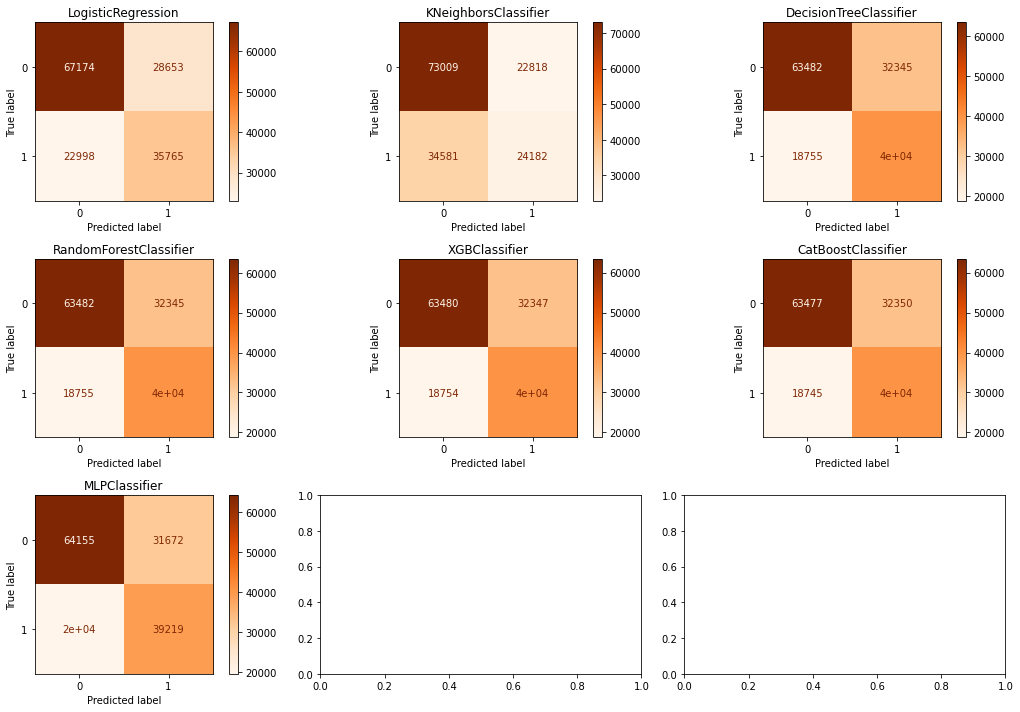

In [147]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for cls, ax in zip(list(classifiers.values()), axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test[selected_features], 
                          y_test, 
                          ax=ax, 
                          cmap='Oranges')
    ax.title.set_text(type(cls).__name__)
    
plt.tight_layout()  

plt.show()

# Performance

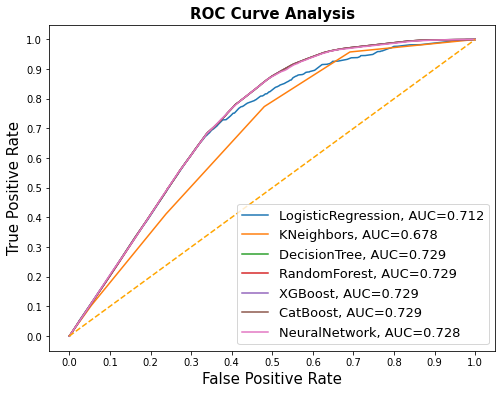

In [148]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [149]:
result_table.iloc[:,:4]

,accuracy,presicion,recall,f1_score
classifiers,,,,
LogisticRegression,0.665884,0.672825,0.665884,0.668474
KNeighbors,0.628702,0.616217,0.628702,0.618789
DecisionTree,0.669448,0.688699,0.669448,0.673965
RandomForest,0.669448,0.688699,0.669448,0.673965
XGBoost,0.669442,0.688698,0.669442,0.673959
CatBoost,0.669481,0.688758,0.669481,0.673999
NeuralNetwork,0.668698,0.685429,0.668698,0.673002


# Hyperparameter Tuning

Optimal number of features: 2
Selected features: ['total_transactions', 'search_count']


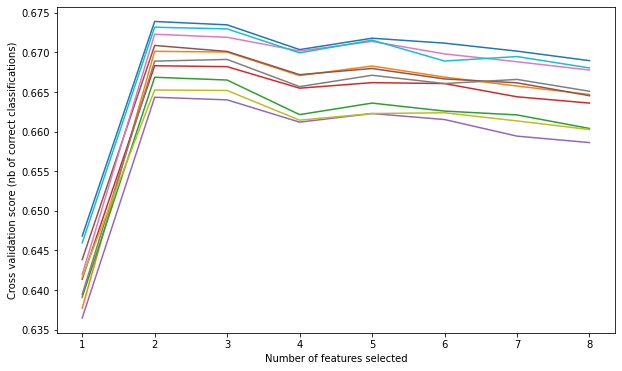

In [150]:
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')

X = feature_all.iloc[:, 5:13]

rfecv.fit(X, y)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))

plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

plt.show()

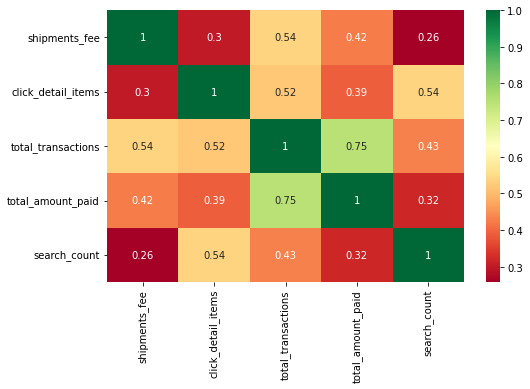

In [151]:
Selected_features = ['shipments_fee', 'click_detail_items', 'total_transactions', 'total_amount_paid', 'search_count']
X = feature_all[Selected_features]

plt.subplots(figsize=(8,5))

sns.heatmap(X.corr(), annot=True, cmap="RdYlGn")

plt.show()

# Model evaluation based on simple train/test split using train_test_split() function

Train/Test split results:
LogisticRegression accuracy is 0.664
LogisticRegression log_loss is 0.590
LogisticRegression auc is 0.710


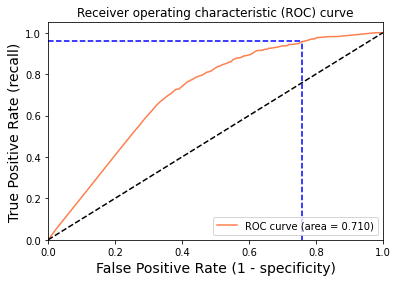

Using a threshold of 0.154 guarantees a sensitivity of 0.958 and a specificity of 0.240, i.e. a false positive rate of 75.97%.


In [152]:
# create X (features) and y (response)
X = feature_all[Selected_features]
y = feature_all['flagging']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# check classification scores of logistic regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)

print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0,1], [0,1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)

plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")

plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [153]:
# 10-fold cross-validation logistic regression
logreg = LogisticRegression()

# Use cross_val_score function
# We are passing the entirety of X and y, not X_train or y_train, it takes care of splitting the data
# cv=10 for 10 folds
# scoring = {'accuracy', 'neg_log_loss', 'roc_auc'} for evaluation metric - althought they are many
scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring='neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring='roc_auc')

print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.667
LogisticRegression average log_loss is 0.589
LogisticRegression average auc is 0.712


# Neural Network

In [155]:
# Membagi dataIv menjadi feature (x) & target (y)
x_nn = feature_all[['shipments_fee', 'click_detail_items', 'total_transactions', 'total_amount_paid', 'search_count']]
y_nn = feature_all['flagging']

In [156]:
# Split dataset
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(x_nn, y_nn, test_size=0.3, random_state=25) 

# create an object model and store it in the clf variable
clf = MLPClassifier(hidden_layer_sizes=(10,8),
                    random_state=25,
                    verbose=True,
                    learning_rate_init=0.001)

# Menyesuaikan (fitting) data dengan model
clf.fit(x_train_nn, y_train_nn)

# Buat prediksi pada test dataset
ypred_nn = clf.predict(x_test_nn)

# Menghitung akurasi data
print("Test accuracy: ", accuracy_score(y_test_nn, ypred_nn))

Iteration 1, loss = 0.59241064
Iteration 2, loss = 0.57407309
Iteration 3, loss = 0.57203400
Iteration 4, loss = 0.57065307
Iteration 5, loss = 0.56991989
Iteration 6, loss = 0.56937371
Iteration 7, loss = 0.56905426
Iteration 8, loss = 0.56891324
Iteration 9, loss = 0.56867816
Iteration 10, loss = 0.56815276
Iteration 11, loss = 0.56778534
Iteration 12, loss = 0.56750192
Iteration 13, loss = 0.56743809
Iteration 14, loss = 0.56731808
Iteration 15, loss = 0.56719237
Iteration 16, loss = 0.56705614
Iteration 17, loss = 0.56672078
Iteration 18, loss = 0.56658032
Iteration 19, loss = 0.56644341
Iteration 20, loss = 0.56626047
Iteration 21, loss = 0.56639778
Iteration 22, loss = 0.56631224
Iteration 23, loss = 0.56637478
Iteration 24, loss = 0.56611879
Iteration 25, loss = 0.56605795
Iteration 26, loss = 0.56615804
Iteration 27, loss = 0.56594780
Iteration 28, loss = 0.56603646
Iteration 29, loss = 0.56610873
Iteration 30, loss = 0.56583946
Iteration 31, loss = 0.56578411
Iteration 32, los

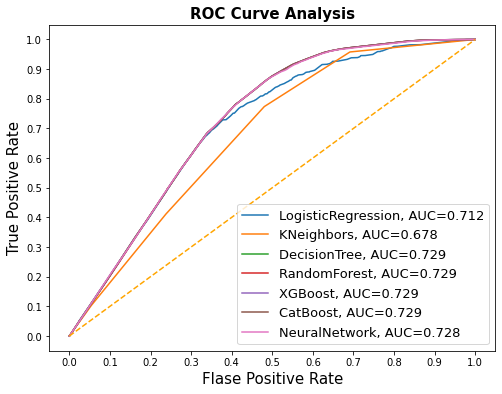

In [157]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

# K-Means

In [158]:
# convert to numpy array
dataKmeans = feature_all[['shipments_fee', 'click_detail_items', 'total_transactions', 'total_amount_paid', 'search_count', 'flagging']]
dataKmeans = dataKmeans.values.tolist()
dataKmeans = np.array(dataKmeans)

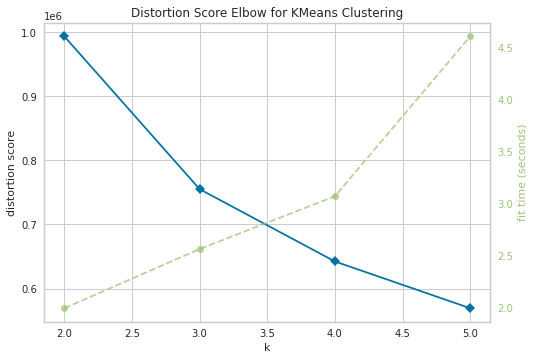

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [160]:
train_data_kmeans, test_data_kmeans = train_test_split(dataKmeans, test_size=0.3, random_state=123)

# instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,6))

visualizer.fit(train_data_kmeans) # fit the data to the visualizer
visualizer.poof()  

In [161]:
## Randomly place the centroids of the three clusters 
c1 = [float(np.random.randint(4,8)),float(np.random.randint(1,5))]
c2 = [float(np.random.randint(4,8)),float(np.random.randint(1,5))]

# Intialize the number of iterations you want to run 
epochs = 1
dataKmeansLength = dataKmeans.shape[0]

while(epochs <= dataKmeansLength):
    cluster_1 = []
    cluster_2 = []
    
    for point in train_data_kmeans:
        # find the eucledian distance between all points the centroid
        dis_point_c1 = ((c1[0]-point[0])**2 + (c1[1]-point[1])**2)**0.5
        dis_point_c2 = ((c2[0]-point[0])**2 + (c2[1]-point[1])**2)**0.5
        distances = [dis_point_c1,dis_point_c2]
        
        # find the closest centroid to the point and assign the point to that cluster
        pos = distances.index(min(distances))
        
        if(pos == 0):
            cluster_1.append(point)
        else:
            cluster_2.append(point)
            
    # store the centroid values to calculate new centroid values 
    prev_c1 = c1
    prev_c2 = c2
    cluster_1 = np.array(cluster_1)
    cluster_2 = np.array(cluster_2)
    
    # find mean of all points within a cluster and make it as the centroid 
    if(len(cluster_1) != 0):
        c1 = [sum(cluster_1[:,0])/float(len(cluster_1)),
              sum(cluster_1[:,1])/float(len(cluster_1))]
    if(len(cluster_2) != 0):
        c2 = [sum(cluster_2[:,0])/float(len(cluster_2)),
              sum(cluster_2[:,1])/float(len(cluster_2))]
        
    # if centroid values hasn't changed, algorithm has convereged 
    if(prev_c1 == c1 and prev_c2 == c2):
        print("Converged")
        break
        
    print(epochs)
    epochs += 1

1
2
3
4
Converged


In [162]:
kmeans_pred = []

for point in test_data_kmeans:
    # find distance between test data point and centroids
    dis_point_c1 = ((c1[0]-point[0])**2 + (c1[1]-point[1])**2)**0.5
    dis_point_c2 = ((c2[0]-point[0])**2 + (c2[1]-point[1])**2)**0.5
    
    # find the cluster to which the point is closest to and append it to pred
    distances = [dis_point_c1,dis_point_c2]
    pos = distances.index(min(distances))
    
    kmeans_pred.append(pos)

[4.842237278576358, 1.9913100264929167]


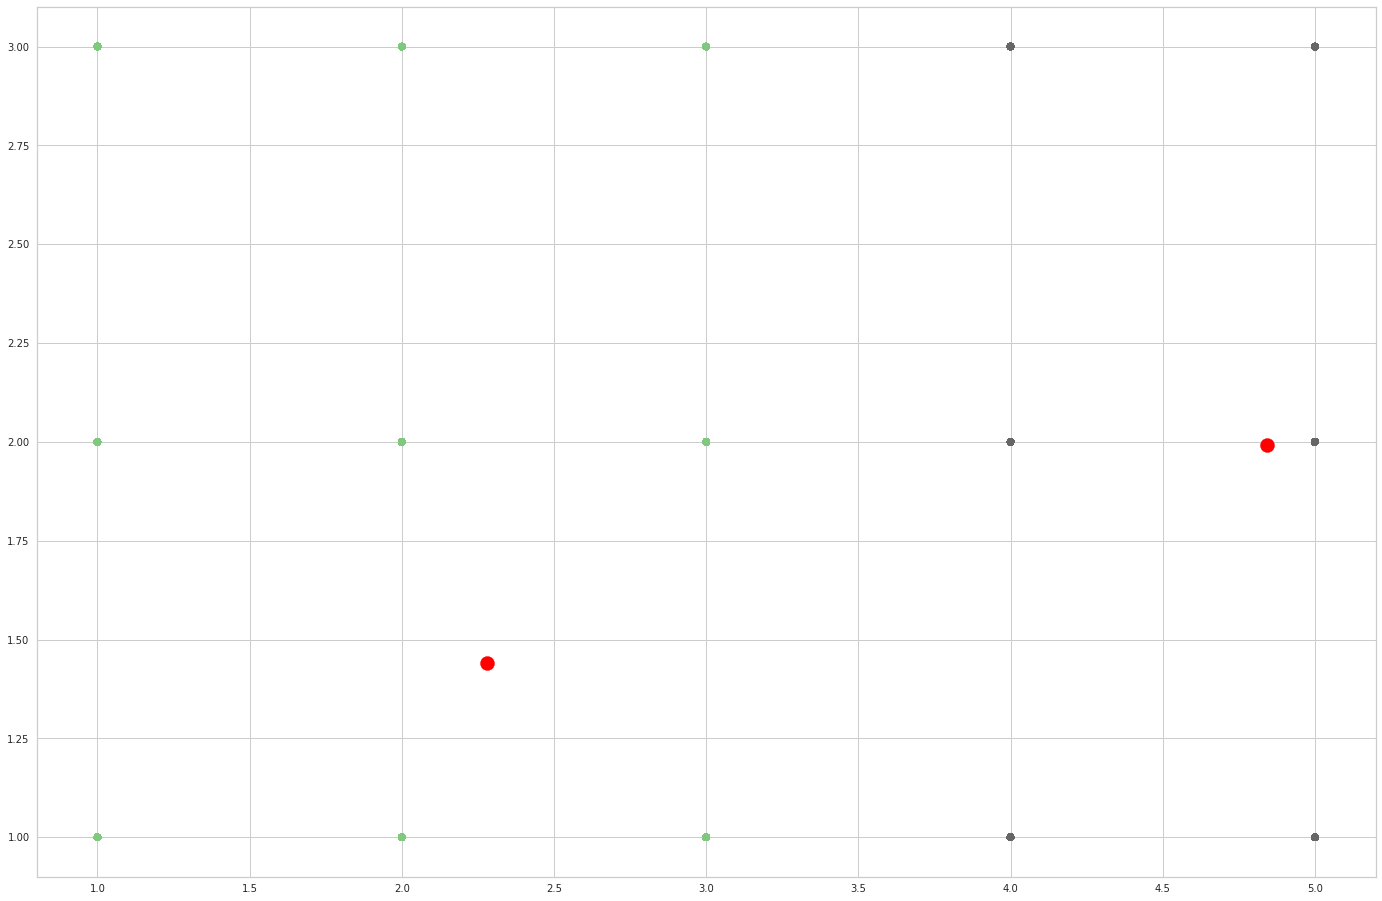

In [163]:
fig = plt.figure(figsize=(24,16))

centroid = np.stack((c1,c2), axis=0)

print(c2)

img = plt.scatter(test_data_kmeans[:,0], test_data_kmeans[:,1], c = kmeans_pred, marker = "o", cmap="Accent")

plt.scatter(centroid[:,0], centroid[:,1],c='red' , marker="o", s=200)

plt.show()